In [2]:
import nltk
import pandas as pd
import numpy as np
#nltk.download('stopwords')

from nltk.corpus import stopwords

# Setting Up

#### Importing data

In [3]:
full_df = pd.read_csv('../data/blogs_with_analytics.csv', sep='\t', index_col='index')

full_df = full_df.dropna(how='any', axis=0) #Get rid of any blogs that could cause models to crash

#Formatting values into easy-to-use arrays for models
texts = full_df['text'].values
titles = full_df['title'].values
categories = full_df['category'].values

#### Preprocessing

In [4]:
from nltk import SnowballStemmer, WordNetLemmatizer
import gensim

In [5]:
#Guting's preprocessing functions
stemmer = SnowballStemmer("english")
def lemmatize_stem(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text, min_len=3):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stem(token))
    return result

#Preprocessing texts
lem_texts = []
for t in texts:
    l = preprocess(t)
    lem_texts.append(' '.join(l))

print(lem_texts[0])

need awesom peopl reason leav futuric covid work home awesom compani cultur peopl mean lose best work compani seven year futuric think time chang compani end go offic time covid know team felt small miss social interact easi come straight futuric touch futuric peopl awesom peopl futuric smart actual thing passion thing interest lead chao passion peopl want chang world love work impact world know lot place come futuric futuricean feel like famili learn embrac chao general structur futuric peopl thing creativ chao good thing spirit chang world compani differ hierarch compani chang thing small restrict advis look chang look stop usual chang easi advis look chang look stop usual major life chang time life spend year think jump simpl complex complex human fear chang bring chang futuric helsinki futuric tamper quick decis leap unknown fiancé decid tamper child fresh start wider famili turn love tamper fact live near centr citi forest nearbi best world trip work lot wildlif backyard chang sak

#### Getting Features with TF-IDF

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
#Mainly going to use this model as features
tf_idf_vectorizer = TfidfVectorizer(use_idf=True, norm='l2')

tf_idf_matrix = tf_idf_vectorizer.fit_transform(lem_texts)

#### Plotting Points

In [41]:
#Color table to keep colors consistent throughout graphs
color_table = {
    "Opinion": '#000000',              
    "Technology": '#497856',          
    "Innovation & Design": '#785d49', 
    "Ways of Working": '#744978', 
    "Culture": '#494b78',       
    "Events": '#FD69F3',        
    "Emerging Tech": '#c300ff', 
    "Strategy": '#05414a', 
    "News": '#4a4805',     
    "Learning": '#054a0b', 
    "Projects": '#5c5c5c', 
    "Product": '#301201' 
}

In [9]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

c:\Users\chaul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\chaul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\chaul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


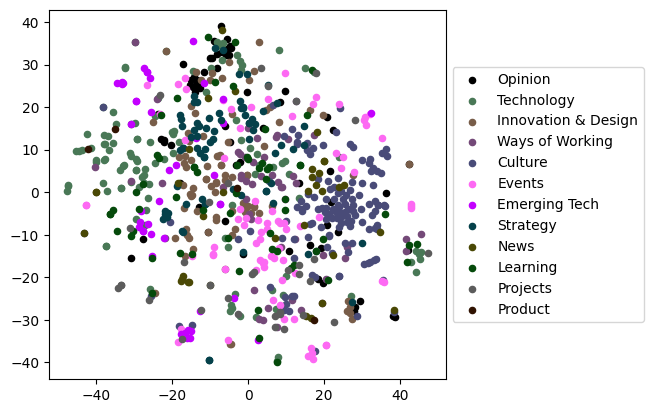

In [42]:
dense_matrix = tf_idf_matrix.todense()

embeddings = TSNE(n_components = 2)
Y = embeddings.fit_transform(dense_matrix)

plot_df = pd.DataFrame({'category': categories, 'x': Y[:, 0], 'y': Y[:, 1]}, columns=['category', 'x', 'y'])

fig, ax = plt.subplots()
for tag in color_table.keys():
    tmp = plot_df[plot_df['category'] == tag]
    
    ax.scatter(tmp['x'].values, tmp['y'].values, c=color_table[tag], label=tag, s=20)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Culture seems to be relatively well clustered. If classifier show some logic there then there is definitely some potential in clustering

# Models

#### Chekcing whether vectors are classifiable with KNeighbors

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
import matplotlib

In [50]:
#Setting up a map from text to integer for easier plotting
tag_to_num = {"Opinion": 0,
              "Technology": 1,
              "Innovation & Design": 2,
              "Ways of Working": 3,
              "Culture": 4,
              "Events": 5,
              "Emerging Tech": 6,
              "Strategy": 7,
              "News": 8,
              "Learning": 9,
              "Projects": 10,
              "Product": 11}

tags = [tag_to_num[elem] for elem in categories]
print(len(tags))


k_neigh = KNeighborsClassifier(n_neighbors=3, metric='cosine')

#500 training elements(Just randomly chose this for)
k_neigh.fit(tf_idf_matrix[:500], tags[:500])

778


KNeighborsClassifier(metric='cosine', n_neighbors=3)

c:\Users\chaul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


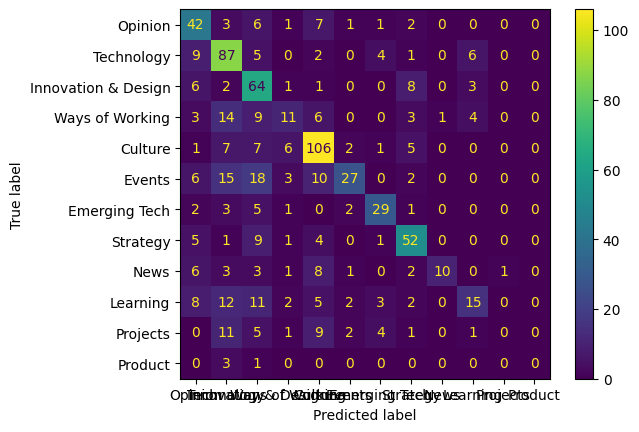

In [86]:
#Confusion Matrix on whole remaining text
fig, ax = plt.subplots()
plot_confusion_matrix(k_neigh, tf_idf_matrix, tags, labels=np.unique(tags), display_labels=tag_to_num.keys(), ax=ax)

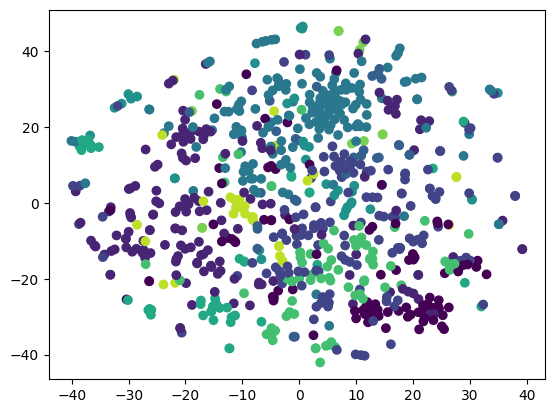

In [14]:
pred_lab = k_neigh.predict(tf_idf_matrix)

plt.scatter(Y[:, 0], Y[:, 1], c=pred_lab)

In [15]:
err = 0
for i in range(len(pred_lab)):
    if pred_lab[i] != tags[i]:
        err += 1
print(err/len(pred_lab))

0.4305912596401028


Further testing in this same manner showed that Culture showed an error rate of only 4 percent. This probably means that the texts can indeed be classified but the current tags are not properly representing groups

## Clustering

#### Testing 3 clustering models

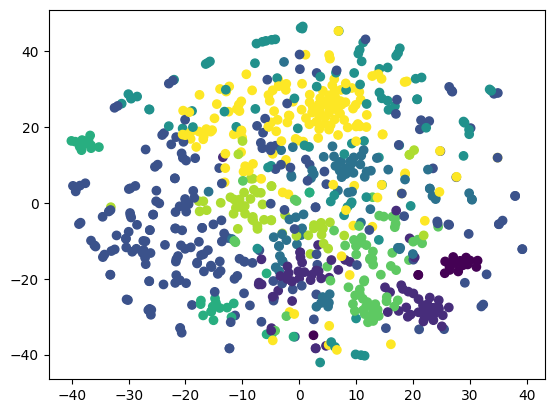

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans_model = KMeans(n_clusters=9) #9 comes from Guting's topic modeling

kmeans_model.fit(tf_idf_matrix)
kmeans_l = kmeans_model.labels_

plt.scatter(Y[:, 0], Y[:, 1], c=kmeans_l)

In [17]:
print(silhouette_score(tf_idf_matrix, kmeans_model.labels_))  #Score close to 0, so not good neither bad. We can at least see some clusters occuring

0.01076586539780268


In [18]:
#Grid Search for DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

best_result = -2
best_params = (0, 1)

for n in range(1, 110, 1):
    for m in range(2, 10):
        temp_mod = DBSCAN(eps=n/10, min_samples=m, metric='cosine').fit(tf_idf_matrix)
        if len(np.unique(temp_mod.labels_)) == 1:
            sil = -2
        else:
            sil = silhouette_score(tf_idf_matrix, temp_mod.labels_)
        if sil > best_result:
            best_result = sil
            best_params = (n, m)


print(best_params)
print(best_result)

(9, 7)
0.03271940155234104


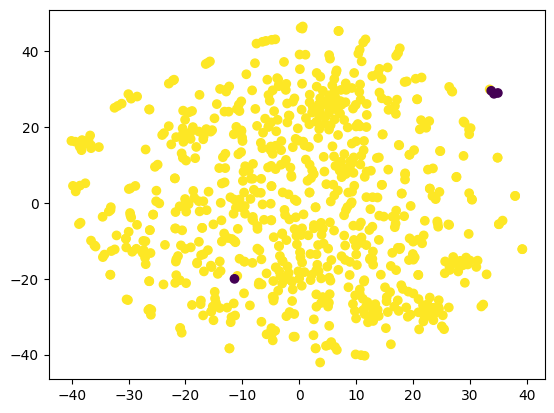

In [19]:
best_db = DBSCAN(eps=0.9, min_samples=7, metric='cosine').fit(tf_idf_matrix)

plt.scatter(Y[:, 0], Y[:, 1], c=best_db.labels_)


Ok let's avoid DBSCAN

c:\Users\chaul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


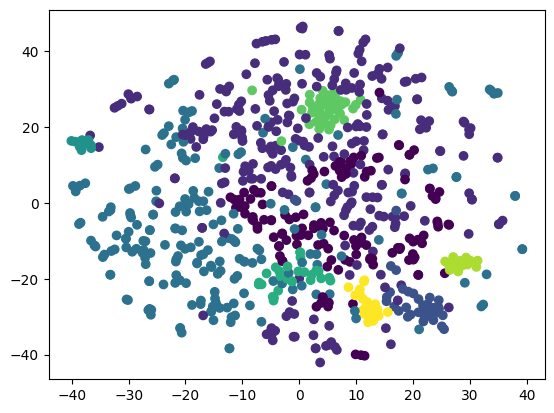

In [20]:
#Agglo cluster
from sklearn.cluster import AgglomerativeClustering

agglo_model = AgglomerativeClustering(n_clusters=9, affinity='euclidean').fit(dense_matrix)
plt.scatter(Y[:, 0], Y[:, 1], c=agglo_model.labels_)

Both Agglo and KMeans seem usable, let's see whether they can cluster Culture properly like the classifier does

#### Comparing Models

In [21]:
kmeans_comp = pd.DataFrame({'title': np.array(titles), 'real': np.array(categories), 'pred': np.array(kmeans_l)}, columns=['title', 'real', 'pred'])

for i in range(0, 9):
    print(str(i) + ": " + str(kmeans_comp[kmeans_comp['pred'] == i].shape[0]))

0: 18
1: 71
2: 216
3: 75
4: 93
5: 31
6: 65
7: 54
8: 155


In [22]:
for i in range(0, 9):
    temp = {}
    for elem in kmeans_comp[kmeans_comp['pred'] == i]['real'].values:
        if elem in temp:
            temp[elem] += 1
        else:
            temp[elem] = 1
    temp = {k: v for k, v in sorted(temp.items(), key=lambda item: item[1])}
    print(str(i) + ": " + str(temp))

0: {'Culture': 1, 'Technology': 1, 'Events': 1, 'Emerging Tech': 2, 'Strategy': 3, 'Opinion': 4, 'Innovation & Design': 6}
1: {'Projects': 1, 'Emerging Tech': 1, 'Learning': 1, 'News': 2, 'Events': 3, 'Innovation & Design': 10, 'Technology': 13, 'Opinion': 17, 'Strategy': 23}
2: {'Strategy': 2, 'Product': 3, 'Culture': 6, 'Innovation & Design': 11, 'News': 11, 'Ways of Working': 11, 'Opinion': 13, 'Emerging Tech': 16, 'Projects': 17, 'Events': 22, 'Learning': 25, 'Technology': 79}
3: {'Technology': 1, 'Projects': 1, 'Culture': 2, 'News': 2, 'Emerging Tech': 3, 'Opinion': 3, 'Ways of Working': 5, 'Strategy': 5, 'Learning': 9, 'Events': 14, 'Innovation & Design': 30}
4: {'Strategy': 2, 'Ways of Working': 3, 'Emerging Tech': 3, 'Technology': 4, 'Projects': 4, 'Learning': 5, 'Innovation & Design': 6, 'News': 13, 'Culture': 25, 'Events': 28}
5: {'Opinion': 1, 'Learning': 1, 'Culture': 2, 'Events': 2, 'Strategy': 2, 'Technology': 3, 'Projects': 3, 'Emerging Tech': 17}
6: {'Emerging Tech': 1,

In [23]:
agglo_comp = pd.DataFrame({'title': np.array(titles), 'real': np.array(categories), 'pred': np.array(agglo_model.labels_)}, columns=['title', 'real', 'pred'])

for i in range(0, 9):
    print(str(i) + ": " + str(agglo_comp[agglo_comp['pred'] == i].shape[0]))

0: 134
1: 283
2: 35
3: 216
4: 10
5: 28
6: 38
7: 14
8: 20


In [24]:
for i in range(0, 9):
    temp = {}
    for elem in agglo_comp[agglo_comp['pred'] == i]['real'].values:
        if elem in temp:
            temp[elem] += 1
        else:
            temp[elem] = 1
    temp = {k: v for k, v in sorted(temp.items(), key=lambda item: item[1])}
    print(str(i) + ": " + str(temp))

0: {'Product': 1, 'Culture': 2, 'Emerging Tech': 2, 'Projects': 2, 'Opinion': 5, 'Events': 6, 'Technology': 7, 'News': 8, 'Learning': 18, 'Ways of Working': 20, 'Strategy': 24, 'Innovation & Design': 39}
1: {'Product': 1, 'Emerging Tech': 6, 'Technology': 10, 'Learning': 13, 'Ways of Working': 13, 'Projects': 17, 'Opinion': 18, 'News': 18, 'Innovation & Design': 18, 'Strategy': 22, 'Events': 58, 'Culture': 89}
2: {'Events': 1, 'Learning': 2, 'Ways of Working': 2, 'News': 2, 'Strategy': 3, 'Innovation & Design': 3, 'Technology': 9, 'Opinion': 13}
3: {'Product': 2, 'Strategy': 5, 'Culture': 7, 'News': 7, 'Opinion': 9, 'Innovation & Design': 9, 'Projects': 14, 'Events': 14, 'Ways of Working': 16, 'Emerging Tech': 24, 'Learning': 27, 'Technology': 82}
4: {'Culture': 1, 'Events': 1, 'Projects': 1, 'Emerging Tech': 7}
5: {'Events': 1, 'Emerging Tech': 2, 'Opinion': 4, 'Technology': 4, 'Innovation & Design': 6, 'Strategy': 11}
6: {'Innovation & Design': 1, 'Opinion': 2, 'Culture': 35}
7: {'Cu

Welp, both of them do well in both clustering Culture, but also clustering technology. I'm gonna run manual tests you can ignore and just skip to the TLDR

TLDR:
KMeans does a great job clustering, and while it is not regular in its clusters, some seem to appear everytime. Those are:
-FutuStories and similar style docs
-Mobility
-Energy
-Data
-Cloud
-Strategy

Some others that appear but sometimes get merged with others:
-Health
-Robotics
-Design

In our case, I saved a model's results which seemed to do a good job clustering without overfitting some topics. These results are saved  in cluster_temp_save.csv

# Visualising Results

In [25]:
tf_idf_matrix

<778x14752 sparse matrix of type '<class 'numpy.float64'>'
	with 187256 stored elements in Compressed Sparse Row format>

In [26]:
#I did my original clustering with blog_text, so gonna make sure both contain the same docs

analytics = pd.read_csv("../data/blogs_with_analytics.csv", sep='\t')

save = pd.read_csv("cluster_temp_save.csv", sep='²')
s_title = save['title'].values
s_pred = save['cluster_pred'].values
for i in range(len(s_pred)):
    if s_pred[i] == "Company oriented Strategy":
        s_pred[i] = "Company"

to_remove = []
pg_views = []
for i in range(len(s_title)):
    idk = analytics[analytics['title'] == s_title[i]]['pageviews'].values
    if len(idk) == 0:
        to_remove.append(i)
        continue
    if len(idk) > 1:
        pg_views.append(idk.sum())
    else:
        pg_views.append(idk[0])

for elem in to_remove:
    s_title = np.delete(s_title, elem)
    s_pred = np.delete(s_pred, elem)

print(len(s_title), len(s_pred), len(pg_views))



C:\Users\chaul\AppData\Local\Temp\ipykernel_31172\2013574201.py:5: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  save = pd.read_csv("cluster_temp_save.csv", sep='²')


778 778 778


#### Pageviews per Cluster

In [27]:
count = {}
views = {}

for i in range(len(s_title)):
    if s_pred[i] in count.keys():
        count[s_pred[i]] += 1
        views[s_pred[i]] += pg_views[i]
    else:
        count[s_pred[i]] = 1
        views[s_pred[i]] = pg_views[i]

avg = {}
for k in count.keys():
    avg[k] = views[k]/count[k]

print(avg)

{'Futustories': 446.4526315789474, 'Company': 611.6444444444444, 'Data': 1738.909090909091, 'Mobility': 367.7894736842105, 'Strategy': 340.57575757575756, 'AI': 733.7352941176471, 'Futurice': 305.8130841121495, 'Design': 917.1538461538462, 'Energy': 367.85714285714283, 'Cloud': 1667.5428571428572}


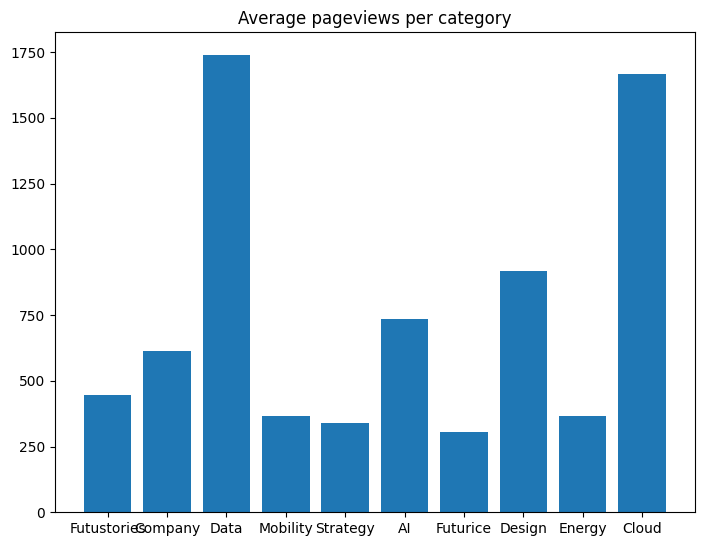

In [28]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(avg.keys(), avg.values())
plt.title('Average pageviews per category')
plt.show()

In [29]:
#Repeating above by combining similar topics
avg_2 = {
    'Futustories': avg['Futustories'],
    'Design/Strategy': (views['Company'] + views['Mobility'] + views['Strategy'] + views['Design'] + views['Strategy'])/(count['Company'] + count['Mobility'] + count['Strategy'] + count['Design'] + count['Strategy']),
    'Tech': (views['Data'] + views['AI'] + views['Cloud'])/(count['Data'] + count['AI'] + count['Cloud']),
    'Futurice': avg['Futurice']
}

print(avg_2)

{'Futustories': 446.4526315789474, 'Design/Strategy': 627.1342281879195, 'Tech': 1511.207650273224, 'Futurice': 305.8130841121495}


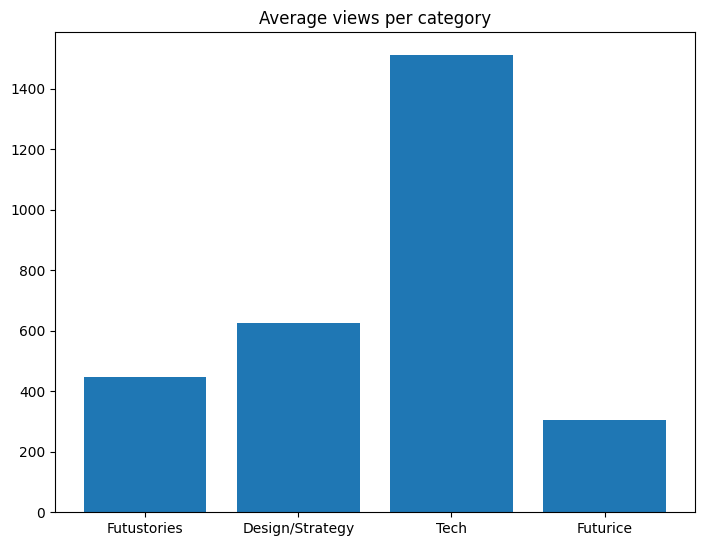

In [30]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(avg_2.keys(), avg_2.values())
plt.title('Average views per category')
plt.show()

#### Visualizing Clusters

In [53]:
cluster_to_num = {
    'Futustories': '#000000',
    'Company': '#497856',
    'Data': '#785d49',
    'Mobility': '#744978',
    'Strategy': '#494b78',
    'AI': '#FD69F3',
    'Futurice': '#c300ff',
    'Design': '#05414a',
    'Energy': '#4a4805',
    'Cloud': '#054a0b'
}

big_to_color = {
    'Tech': '#000000',
    'Design/Strategy': '#FF0000',
    'Futustories': '#27E4DD',
    'Futurice': '#FF7700',
}

big_tag = []
for tag in s_pred:
    if tag in ['Data', 'AI', 'Cloud']:
        big_tag.append('Tech')
    elif tag in ['Company', 'Mobility', 'Strategy', 'Design', 'Energy']:
        big_tag.append("Design/Strategy")
    else:
        big_tag.append(tag)

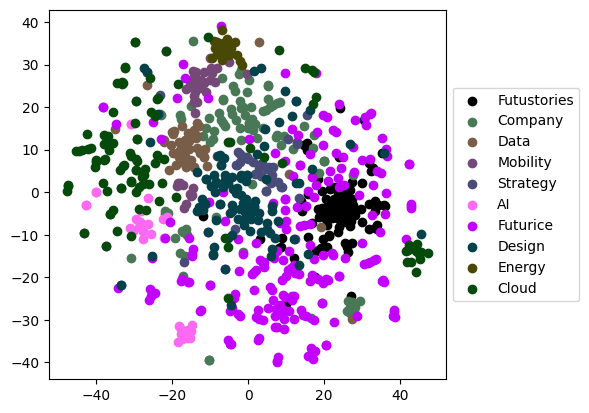

In [55]:
mapping = pd.DataFrame({'tf': tf_idf_matrix, 'category': np.array(s_pred), 'big_category': np.array(big_tag), 'x': Y[:, 0],  'y': Y[:, 1]}, columns=['tf', 'category', 'big_category', 'x', 'y'])
fig, ax = plt.subplots()
for tag in cluster_to_num.keys():
    tmp = mapping[mapping['category'] == tag]
    
    ax.scatter(tmp['x'].values, tmp['y'].values, c=cluster_to_num[tag], label=tag)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

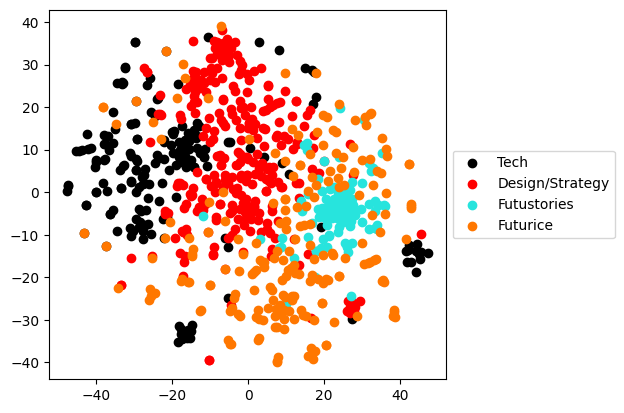

In [57]:
fig, ax = plt.subplots()
for tag in big_to_color.keys():
    tmp = mapping[mapping['big_category'] == tag]
    
    ax.scatter(tmp['x'].values, tmp['y'].values, c=big_to_color[tag], label=tag)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [59]:
#Confusion Matrix
import seaborn as sns
conf = pd.DataFrame({'original': categories, 'big_tag': np.array(big_tag), 'small_tag': np.array(s_pred)}, columns=['original', 'big_tag', 'small_tag'])

In [64]:
#On precise clusters
confusion_dict = {}
for tag in cluster_to_num.keys():
    d = {}
    for t in color_table.keys():
        d[t] = 0
    confusion_dict[tag] = d

for i in range(len(categories)):
    confusion_dict[s_pred[i]][categories[i]] += 1

print(confusion_dict)

{'Futustories': {'Opinion': 4, 'Technology': 2, 'Innovation & Design': 0, 'Ways of Working': 3, 'Culture': 76, 'Events': 4, 'Emerging Tech': 0, 'Strategy': 1, 'News': 3, 'Learning': 2, 'Projects': 0, 'Product': 0}, 'Company': {'Opinion': 8, 'Technology': 3, 'Innovation & Design': 17, 'Ways of Working': 6, 'Culture': 3, 'Events': 6, 'Emerging Tech': 3, 'Strategy': 35, 'News': 5, 'Learning': 3, 'Projects': 1, 'Product': 0}, 'Data': {'Opinion': 3, 'Technology': 6, 'Innovation & Design': 10, 'Ways of Working': 0, 'Culture': 1, 'Events': 2, 'Emerging Tech': 3, 'Strategy': 14, 'News': 1, 'Learning': 3, 'Projects': 0, 'Product': 1}, 'Mobility': {'Opinion': 12, 'Technology': 3, 'Innovation & Design': 13, 'Ways of Working': 0, 'Culture': 0, 'Events': 1, 'Emerging Tech': 1, 'Strategy': 6, 'News': 1, 'Learning': 1, 'Projects': 0, 'Product': 0}, 'Strategy': {'Opinion': 2, 'Technology': 4, 'Innovation & Design': 1, 'Ways of Working': 10, 'Culture': 3, 'Events': 0, 'Emerging Tech': 0, 'Strategy': 3,

In [65]:
confusion_big = {}
for tag in big_to_color.keys():
    d = {}
    for t in color_table.keys():
        d[t] = 0
    confusion_big[tag] = d

for i in range(len(categories)):
    confusion_big[big_tag[i]][categories[i]] += 1

print(confusion_big)

{'Tech': {'Opinion': 6, 'Technology': 75, 'Innovation & Design': 11, 'Ways of Working': 7, 'Culture': 3, 'Events': 9, 'Emerging Tech': 27, 'Strategy': 16, 'News': 4, 'Learning': 19, 'Projects': 4, 'Product': 2}, 'Design/Strategy': {'Opinion': 37, 'Technology': 21, 'Innovation & Design': 63, 'Ways of Working': 26, 'Culture': 10, 'Events': 25, 'Emerging Tech': 11, 'Strategy': 52, 'News': 9, 'Learning': 22, 'Projects': 9, 'Product': 1}, 'Futustories': {'Opinion': 4, 'Technology': 2, 'Innovation & Design': 0, 'Ways of Working': 3, 'Culture': 76, 'Events': 4, 'Emerging Tech': 0, 'Strategy': 1, 'News': 3, 'Learning': 2, 'Projects': 0, 'Product': 0}, 'Futurice': {'Opinion': 16, 'Technology': 16, 'Innovation & Design': 11, 'Ways of Working': 15, 'Culture': 46, 'Events': 43, 'Emerging Tech': 5, 'Strategy': 4, 'News': 19, 'Learning': 17, 'Projects': 21, 'Product': 1}}


C:\Users\chaul\AppData\Local\Temp\ipykernel_31172\4107473443.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  small_df = small_df.append(v, ignore_index=True)
C:\Users\chaul\AppData\Local\Temp\ipykernel_31172\4107473443.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  small_df = small_df.append(v, ignore_index=True)
C:\Users\chaul\AppData\Local\Temp\ipykernel_31172\4107473443.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  small_df = small_df.append(v, ignore_index=True)
C:\Users\chaul\AppData\Local\Temp\ipykernel_31172\4107473443.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  small_df = small_df.append(v, ignore_index=Tr

<AxesSubplot: ylabel='Tag'>

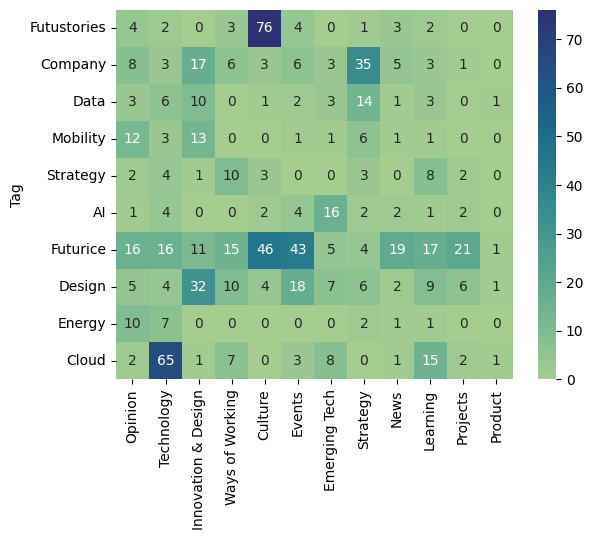

In [84]:
#Precise confusion matrix
small_df = pd.DataFrame(columns=['Tag'] + list(color_table.keys()))
for k, v in confusion_dict.items():
    v['Tag'] = k
    small_df = small_df.append(v, ignore_index=True)
small_df = small_df.set_index('Tag').astype('float32')


sns.heatmap(small_df, annot=True, cmap='crest')

C:\Users\chaul\AppData\Local\Temp\ipykernel_31172\3721403941.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  big_df = big_df.append(v, ignore_index=True)
C:\Users\chaul\AppData\Local\Temp\ipykernel_31172\3721403941.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  big_df = big_df.append(v, ignore_index=True)
C:\Users\chaul\AppData\Local\Temp\ipykernel_31172\3721403941.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  big_df = big_df.append(v, ignore_index=True)
C:\Users\chaul\AppData\Local\Temp\ipykernel_31172\3721403941.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  big_df = big_df.append(v, ignore_index=True)


<AxesSubplot: ylabel='Tag'>

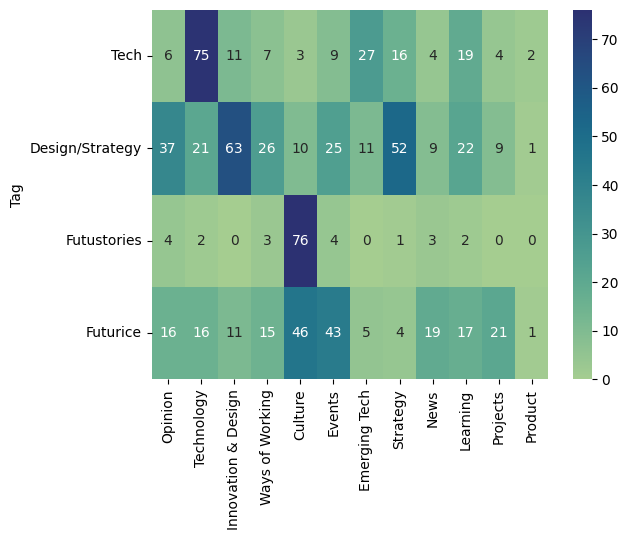

In [85]:
#General confusion matrix
big_df = pd.DataFrame(columns=['Tag'] + list(color_table.keys()))
for k, v in confusion_big.items():
    v['Tag'] = k
    big_df = big_df.append(v, ignore_index=True)
big_df = big_df.set_index('Tag').astype('float32')


sns.heatmap(big_df, annot=True, cmap='crest')

In [105]:
test = pd.read_csv('../data/blogs_with_analytics.csv', sep='\t')
sav = pd.read_csv('cluster_temp_save.csv', sep='²')
sav_t = sav['title'].values
sav_c = sav['cluster_pred'].values

tim = []
rmv = []
for i in range(len(sav_t)):
    temp = test[test['title'] == sav_t[i]]
    chill = temp['avg_time'].values
    tex = temp['text'].values
    if len(chill) == 1 and len(tex) != 0:
        tim.append(chill[0]/(len(tex[0])))
    elif len(chill) > 1:
        tim.append(chill.sum()/(len(tex[0])))
    else:
        rmv.append(i)

for elem in rmv:
    sav_t = np.delete(sav_t, elem)
    sav_c = np.delete(sav_c, elem)

print(len(tim), len(sav_t))

C:\Users\chaul\AppData\Local\Temp\ipykernel_31172\1760246448.py:2: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  sav = pd.read_csv('cluster_temp_save.csv', sep='²')


778 778


In [106]:
count = {}
views = {}

for i in range(len(sav_t)):
    if sav_c[i] in count.keys():
        count[sav_c[i]] += 1
        views[sav_c[i]] += tim[i]
    else:
        count[sav_c[i]] = 1
        views[sav_c[i]] = tim[i]

avg = {}
for k in count.keys():
    avg[k] = views[k]/count[k]

print(avg)

{'Futustories': 0.03684242936849585, 'Company oriented Strategy': 0.042276926651687884, 'Data': 0.030389084260535024, 'Mobility': 0.03033029906123455, 'Strategy': 0.04314144661339079, 'AI': 0.03612532086683246, 'Futurice': 0.07127215662053071, 'Design': 0.025572447440350067, 'Energy': 0.02481158247328212, 'Cloud': 0.039471415077051424}


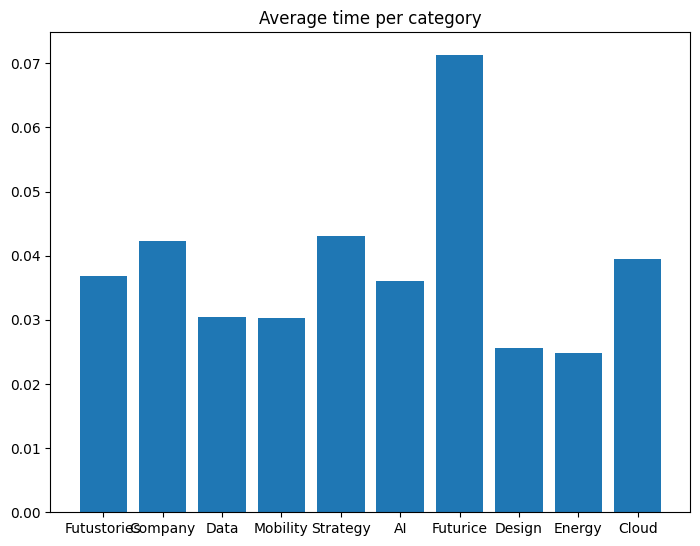

In [109]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
k = list(avg.keys())
for i in range(len(k)):
    if k[i] == "Company oriented Strategy":
        k[i] = "Company"
ax.bar(k, avg.values())
plt.title('Average time per category')
plt.show()

In [112]:
test = pd.read_csv('../data/blogs_with_analytics.csv', sep='\t')
sav = pd.read_csv('cluster_temp_save.csv', sep='²')
sav_t = sav['title'].values
sav_c = sav['cluster_pred'].values

tim = []
pgv = []
rmv = []
for i in range(len(sav_t)):
    temp = test[test['title'] == sav_t[i]]
    chill = temp['bounce_rate'].values
    pgvw = temp['pageviews'].values
    v = 0
    if len(pgvw) == 1:
        v = pgvw[0]
    elif len(pgvw) > 1:
        v = pgvw.sum()
    else:
        rmv.append(i)
        continue
    if len(chill) == 1:
        tim.append(chill[0]*v)
        pgv.append(v)
    elif len(chill) > 1:
        tim.append(chill.sum()*v)
        pgv.append(v)
    else:
        rmv.append(i)

for elem in rmv:
    sav_t = np.delete(sav_t, elem)
    sav_c = np.delete(sav_c, elem)

print(len(tim), len(sav_t), len(pgv))

C:\Users\chaul\AppData\Local\Temp\ipykernel_31172\3268731976.py:2: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  sav = pd.read_csv('cluster_temp_save.csv', sep='²')


778 778 778


In [114]:
count = {}
views = {}

for i in range(len(sav_t)):
    if sav_c[i] in count.keys():
        count[sav_c[i]] += 1
        views[sav_c[i]] += tim[i]/pgv[i]
    else:
        count[sav_c[i]] = 1
        views[sav_c[i]] = tim[i]/pgv[i]

avg = {}
for k in count.keys():
    avg[k] = 1/(views[k]/count[k])

print(avg)

{'Futustories': 2.0044532825431123, 'Company oriented Strategy': 1.5056211791638014, 'Data': 1.4297121496304521, 'Mobility': 1.5234414621406234, 'Strategy': 1.6184046461365498, 'AI': 1.35364094653343, 'Futurice': 1.6407441721644918, 'Design': 1.3982813730281072, 'Energy': 1.6181282579290186, 'Cloud': 1.2749167327461999}


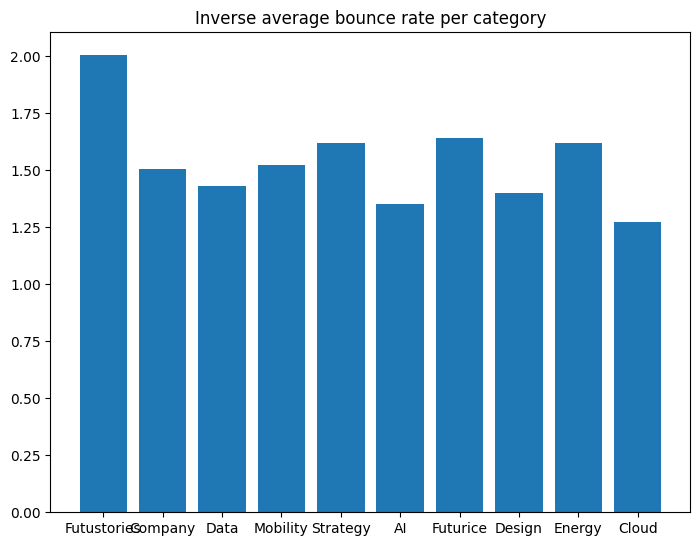

In [115]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
k = list(avg.keys())
for i in range(len(k)):
    if k[i] == "Company oriented Strategy":
        k[i] = "Company"
ax.bar(k, avg.values())
plt.title('Inverse average bounce rate per category')
plt.show()